## Overview
The kernel contains

1. the preprocessing steps to load the data
2. a quick visualization of the color-space
3. training a simple CNN
4. applying the model to the test data
5. creating the RLE test data

In [1]:
## Standard packages for Anaconda 3
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.morphology import closing, opening, disk, label
from skimage.transform import resize   # Function for resizing images
from sklearn.cluster import KMeans   # KMeans algorithm for clustering microscope capture types
from sklearn.model_selection import train_test_split


## Installed separately
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda, Dropout, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K
import seaborn as sns


# Path / Directory Settings
path = './Input_Data/'
stage_label = 'stage1'

print(path)

C:\Users\tomwa\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


./Input_Data/


## Global Hyperparameters - Best So Far Values

In [42]:
def hyperparam_BSF_dict():
    '''
    [None]  -->  [Dict]
    
    Function which restores Dictionary of BSF Hyperparameter values each time it is called
    
    Input: None
    Output: Dictionary of BSF Hyperparameters
    
    '''
    # Initialise dictionary of hyperparameters
    hyperparam_BSF_vals = {}

    # Fixed value for Image Channels
    hyperparam_BSF_vals['IMG_CHANNELS'] = 3

    # Resizing Image Dimensions
    hyperparam_BSF_vals['IMG_WIDTH'] = 256
    hyperparam_BSF_vals['IMG_HEIGHT'] = 256

    # Train:Dev Ratio
    hyperparam_BSF_vals['DEV_SPLIT'] = 0.2   # Fraction split Training Set: Dev Set


    # Fluorescent microscope network
    hyperparam_BSF_vals['LEARNING_RATE_FLUOR'] = 0.001
    hyperparam_BSF_vals['MINIBATCH_FLUOR'] = 16
    hyperparam_BSF_vals['EPOCH_FLUOR'] = 3
    hyperparam_BSF_vals['CLOSING_SIZE_FLUOR'] = 1   # Image Morphology parameter
    hyperparam_BSF_vals['OPENING_SIZE_FLUOR'] = 3   # Image Morphology parameter

    # Fluorescent microscope network
    hyperparam_BSF_vals['LEARNING_RATE_BRIGHT'] = 0.001
    hyperparam_BSF_vals['MINIBATCH_BRIGHT'] = 8
    hyperparam_BSF_vals['EPOCH_BRIGHT'] = 3
    hyperparam_BSF_vals['CLOSING_SIZE_BRIGHT'] = 1   # Image Morphology parameter
    hyperparam_BSF_vals['OPENING_SIZE_BRIGHT'] = 3   # Image Morphology parameter
    
    return hyperparam_BSF_vals


# Load in current BSF values
hyperparam_BSF_vals = hyperparam_BSF_dict()

## Global Hyperparameters - Random Sweep

In [3]:
def hyperparam_sweep(hyperparam_BSF_vals, *swept_params):

    '''
    [Dict], variable positional [string] arguments  -->  [tuple]
    
    Function to randomly sample hyperparameter values given by the positional string arguments and modify the hyperparam 
    dictionary in place for the specified strings
    
    CONSTRAINTS: string arguments should match the keys of the hyperparam dictionary for the desired values to be sampled
    
    Inputs: Hyperparameter dictionary, strings matching the dictionary keys for vals to be modified
    Output: Tuple keeping track of the variables being randomly sampled
    
    '''
    # Initialise lists
    im_list = [128, 256, 512, 1024]
    minibatch_list = [1, 2, 4, 8, 16, 32, 64]
    
    for item in swept_params:    
        
        # Resizing Image Dimensions
        if item == 'IMG_WIDTH':
            hyperparam_BSF_vals['IMG_WIDTH'] = im_list[np.random.randint(0, len(im_list))]
        if item == 'IMG_HEIGHT':
            hyperparam_BSF_vals['IMG_HEIGHT'] = im_list[np.random.randint(0, len(im_list))]

        # Train:Dev Ratio
        if item == 'TRAIN_DEV_SPLIT':
            # Choose ratio of between [0.5, 1.0)
            hyperparam_BSF_vals['TRAIN_DEV_SPLIT'] = 0.5 * np.random.random_sample() + 0.5


        # Fluorescent microscope network
        if item == 'LEARNING_RATE_FLUOR':
            # Sample exponent in range [-4, -1) then convert to log10 scale for choice in range [0.0001, 0.1)
            hyperparam_BSF_vals['LEARNING_RATE_FLUOR'] = 10 ** (3 * np.random.random_sample() -4)
        if item == 'MINIBATCH_FLUOR':
            hyperparam_BSF_vals['MINIBATCH_FLUOR'] = minibatch_list[np.random.randint(0, len(minibatch_list))]
        if item == 'EPOCH_FLUOR':
            hyperparam_BSF_vals['EPOCH_FLUOR'] = np.random.randint(1, 11)   # Samples integer from [1, 10]
        if item == 'CLOSING_SIZE_FLUOR':
            hyperparam_BSF_vals['CLOSING_SIZE_FLUOR'] = np.random.randint(0, 11)   # Image Morphology parameter
        if item == 'OPENING_SIZE_FLUOR':
            hyperparam_BSF_vals['OPENING_SIZE_FLUOR'] = np.random.randint(0, 11)   # Image Morphology parameter

        # Brightfield microscope network
        if item == 'LEARNING_RATE_BRIGHT':
            # Sample exponent in range [-4, 1) then convert to log10 scale for choice in range [0.0001, 10)
            hyperparam_BSF_vals['LEARNING_RATE_BRIGHT'] = 10 ** (5 * np.random.random_sample() -4)
        if item == 'MINIBATCH_BRIGHT':
            hyperparam_BSF_vals['MINIBATCH_BRIGHT'] = minibatch_list[np.random.randint(0, len(minibatch_list))]
        if item == 'EPOCH_BRIGHT':
            hyperparam_BSF_vals['EPOCH_BRIGHT'] = np.random.randint(1, 11)   # Samples integer from [1, 10]
        if item == 'CLOSING_SIZE_BRIGHT':
            hyperparam_BSF_vals['CLOSING_SIZE_BRIGHT'] = np.random.randint(0, 11)   # Image Morphology parameter
        if item == 'OPENING_SIZE_BRIGHT':
            hyperparam_BSF_vals['OPENING_SIZE_BRIGHT'] = np.random.randint(0, 11)   # Image Morphology parameter
    
    return swept_params

## Define Helper Functions in Document

In [4]:
# Function to apply "imread" function to all items in pandas Series
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0) / 255.0


# DICE Score Loss Metrics
def dice_coef(y_true, y_pred, smooth= 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# DICE Score Loss Metrics
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


# Convert pandas Series (row of images) to numpy array
def imageSeries_to_ndArray(x):  
    arr = np.array(x.tolist())
    # Add a new dimension (will be the concatenation dimension) as the first listed dimension
    arr = np.expand_dims(arr, 0)
    # Concatenate all images / masks
    arr = np.concatenate(arr, axis= 0)
    return arr

    
# Convert pandas Series (row of masks) to numpy array
def maskSeries_to_ndArray(x):
    arr = np.array(x.tolist())
    # Add a new dimension (will be the concatenation dimension) as the first listed dimension
    arr = np.expand_dims(np.expand_dims(arr, -1), 0)
    # Concatenate all images / masks
    arr = np.concatenate(arr, axis= 0)
    return arr


# Image Morphology function - apply Closing and Opening to remove isolated pixels and open up conjoined nuclei masks
def clean_img(x, closingSize, openingSize):
    return opening(closing(x, disk(closingSize)), disk(openingSize))


# Following two functions convert masks from 2D arrays to RLE lines for submission
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    
    Returns run length as a list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)



## Load in all Images
Here we load in the images and process the paths so we have the appropriate information for each image

In [5]:
def load_images(path):
    '''
    [string]  -->  [pd.DataFrame]
    
    Function to take in pathname and output pandas DataFrame with info for all Kaggle data
    
    Input: pathname as string
    Output: DataFrame of all training and test data with columns for ['path', 'ImageId', 'TrainingSplit', 'Stage']
    
    '''
    
    # Glob together all the lower level filenames
    all_images = glob(os.path.join(path, 'stage1_*', '*', '*', '*'))
    
    # Instantiate DataFrame
    img_df = pd.DataFrame({'path': all_images})

    # Define lambda functions for following step...
    img_id = lambda in_path: in_path.split('\\')[-3]
    img_type = lambda in_path: in_path.split('\\')[-2]
    img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
    img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]

    # Separate out information from globbed filenames
    img_df['ImageId'] = img_df['path'].map(img_id)
    img_df['ImageType'] = img_df['path'].map(img_type)
    img_df['TrainingSplit'] = img_df['path'].map(img_group)
    img_df['Stage'] = img_df['path'].map(img_stage)
    
    return img_df

In [6]:
img_df = load_images(path)

img_df.sample(3)

,path,ImageId,ImageType,TrainingSplit,Stage
8060,./Input_Data\stage1_train\420f43d21dbaba42bf8c...,420f43d21dbaba42bf8c0995b3a2c85537876d59443377...,masks,train,stage1
4384,./Input_Data\stage1_train\20b20ab049372d184c70...,20b20ab049372d184c705acebe7af026d3580f5fd5a72e...,masks,train,stage1
22859,./Input_Data\stage1_train\bde3727f3a9e8b2b58f3...,bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e6...,masks,train,stage1


## Create Training and Test Data
1. Make training data and load all images into dataframe.

2. Resize images and masks

In [7]:
def train_test_create(img_df, filtr):

    '''
    [pd.DataFrame, string]  -->  [pd.DataFrame]
    
    Filter Training Set and apply Imread to each row
    
    Input: img_df DataFrame of all Kaggle Info, "filtr" a string which is either "train" or "test"
    Output: DataFrame with ['image', 'masks'] columns, each containing image and mask data read in via the "imread" function
    
    '''

    # String to input into the next step - creating a filtered DataFrame of either Train or Test Data 
    query_string = 'TrainingSplit == \"{}\"'.format(filtr)
    
    # Filter Training Set from full globbed DataFrame
    train_df = img_df.query(query_string)

    # Initialise parameters
    train_rows = []
    group_cols = ['Stage', 'ImageId']

    # Loop through filtered DataFrame and store pathnames for each image
    for n_group, n_rows in train_df.groupby(group_cols):
        c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
        if filtr == 'train':
            c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
        c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
        train_rows += [c_row]

    # Instantiate new DataFrame
    train_test_img_df = pd.DataFrame(train_rows)

    # Read in Image and Mask data via "imread"
    train_test_img_df['images'] = train_test_img_df['images'].map(read_and_stack).map(lambda x: x[:, :, :hyperparam_BSF_vals['IMG_CHANNELS']])
    if filtr == 'train':
        train_test_img_df['masks'] = train_test_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))

    # Print Count of Image Series sizes before resizing
    print('Before resizing, value count for images and masks in DataFrame is: \n')
    print(train_test_img_df['images'].map(lambda x: x.shape).value_counts())

    return train_test_img_df


def resize_train_images(train_dev_img_df):

    '''
    [pd.DataFrame]  -->  [pd.DataFrame]
    
    Resize Images and Masks for training data
    
    Input: Train/Dev DataFrame with images and masks of different sizes
    Output: Same DataFrame with images and masks resized to dimensions specified in the notebook global parameters
    
    '''

    # Resize Images
    train_dev_img_df['images'] = train_dev_img_df['images'].map(lambda x: resize(x, (hyperparam_BSF_vals['IMG_HEIGHT'], hyperparam_BSF_vals['IMG_WIDTH'], hyperparam_BSF_vals['IMG_CHANNELS']), mode= 'constant', preserve_range= True))
    train_dev_img_df['masks'] = train_dev_img_df['masks'].map(lambda x: resize(x, (hyperparam_BSF_vals['IMG_HEIGHT'], hyperparam_BSF_vals['IMG_WIDTH']), mode= 'constant', preserve_range= True))

    # Print Count of Image Series sizes again, to check they have all been resized to the correct dimensions
    print('After resizing, value count for images and masks in DataFrame is now: \n')
    print(train_dev_img_df['images'].map(lambda x: x.shape).value_counts())

    return train_dev_img_df


def resize_test_images(test_img_df):
    
    '''
    [pd.DataFrame]  -->  [pd.DataFrame]
    
    Resize Images for test data and store original image dimensions for upscaling masks before RLE submission
    
    Input: Train/Dev DataFrame with images of different sizes
    Output: Same DataFrame with images resized to dimensions specified in the notebook global parameters and original
    dimensions stored in "orig_img_shape" column
    
    '''

    # Save original dimensions of each image for upsizing masks before RLE submission
    test_img_df['orig_img_shape'] = test_img_df['images'].map(lambda x: list(x.shape))
    ix = np.random.randint(0, (len(test_img_df)))
    print(test_img_df['orig_img_shape'].iloc[ix])

    test_img_df['newImages'] = test_img_df['images'].map(lambda x: resize(x, (hyperparam_BSF_vals['IMG_HEIGHT'], hyperparam_BSF_vals['IMG_WIDTH'], hyperparam_BSF_vals['IMG_CHANNELS']), 
                                                                       mode= 'constant', preserve_range= True))
    
    print('After resizing, value count for images and masks in DataFrame is now: \n')
    print(test_img_df['newImages'].map(lambda x: x.shape).value_counts())

    return test_img_df



In [8]:
%%time

# Load in training data
train_dev_img_df = train_test_create(img_df, 'train')

# Resize training data
train_dev_img_df = resize_train_images(train_dev_img_df)

Before resizing, value count for images and masks in DataFrame is: 

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64
After resizing, value count for images and masks in DataFrame is now: 

(256, 256, 3)    670
Name: images, dtype: int64
Wall time: 4min 40s


In [9]:
%%time

# Load in test data
test_img_df = train_test_create(img_df, 'test')

# Resize training data
test_img_df = resize_test_images(test_img_df)

Before resizing, value count for images and masks in DataFrame is: 

(256, 256, 3)    24
(512, 680, 3)     8
(512, 640, 3)     8
(520, 696, 3)     4
(519, 253, 3)     4
(520, 348, 3)     4
(260, 347, 3)     4
(524, 348, 3)     4
(519, 161, 3)     2
(519, 162, 3)     2
(390, 239, 3)     1
Name: images, dtype: int64
[256, 256, 3]
After resizing, value count for images and masks in DataFrame is now: 

(256, 256, 3)    65
Name: newImages, dtype: int64
Wall time: 4.59 s


## Apply k-means clustering to training dataframe to separate out brightfield and fluorescence imaging types

In [10]:
def kmeans_filtering(train_test_img_df):

    '''
    [pd.DataFrame]  -->  [pd.DataFrame]
    
    Applies KMeans function (from sklearn) to label images as either 0 (Fluorescent) or 1 (Brightfield) and appends labels to
    DataFrame
    
    Input: Train or Test DataFrame
    Output: Same DataFrame with additional column 'imagingType', containing the labels
    
    '''
    # Get channel intensities from training image set
    train_test_img_df['red'] = train_test_img_df['images'].map(lambda x: np.mean(x[:, :, 0]))
    train_test_img_df['blue'] = train_test_img_df['images'].map(lambda x: np.mean(x[:, :, 1]))
    train_test_img_df['green'] = train_test_img_df['images'].map(lambda x: np.mean(x[:, :, 2]))
    train_test_img_df['grey'] = train_test_img_df['images'].map(lambda x: np.mean(x))

    # Convert pd.Series to numpy array xIntensities of dims [nImages x 4]
    xRed = np.expand_dims(np.array(train_test_img_df['red'].tolist()), -1)
    xBlue = np.expand_dims(np.array(train_test_img_df['blue'].tolist()), -1)
    xGreen = np.expand_dims(np.array(train_test_img_df['green'].tolist()), -1)
    xGrey = np.expand_dims(np.array(train_test_img_df['grey'].tolist()), -1)
    xIntensities = np.concatenate((xRed, xBlue, xGreen, xGrey), axis= -1)

    # Apply KMeans function (from sklearn) to label images as either 0 (Fluorescent) or 1 (Brightfield)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(xIntensities)
    
    # Append labels to DataFrame
    train_test_img_df['imagingType'] = kmeans.labels_
    
    ## The final steps check label 0 corresponds to Fluorescence and label 1 corresponds to Brightfield.
    ## This ensures consistency in the clustering labels between the training and test data
    
    # Lower mean of intensities should correspond to Fluorescence and higher mean to Brightfield...
    label_0_avg = np.mean(xIntensities[kmeans.labels_ == 0, :])
    label_1_avg = np.mean(xIntensities[kmeans.labels_ == 1, :])

    # If not, invert the labels
    temp = kmeans.labels_
    # Convert array of Int 0s and 1s to Bool 0s and 1s, so it can be inverted if necessary
    temp2 = temp.astype(bool)
    if label_0_avg > label_1_avg:
        temp2 = np.invert(temp2).astype(int)
        # Reassign the labels
        train_test_img_df['imagingType'] = temp2
        
    
    return train_test_img_df

# Apply function to Training / Dev data
train_dev_img_df = kmeans_filtering(train_dev_img_df)
train_dev_fluor_df = train_dev_img_df.query('imagingType == "0"')
train_dev_bright_df = train_dev_img_df.query('imagingType == "1"')

# Apply function to Test data
test_img_df = kmeans_filtering(test_img_df)
test_fluor_df = test_img_df.query('imagingType == "0"')
test_bright_df = test_img_df.query('imagingType == "1"')

## Plot example of each from the Training and Test Sets

Step to check accurate separation of dataset into Fluorescent and Brightfield sets

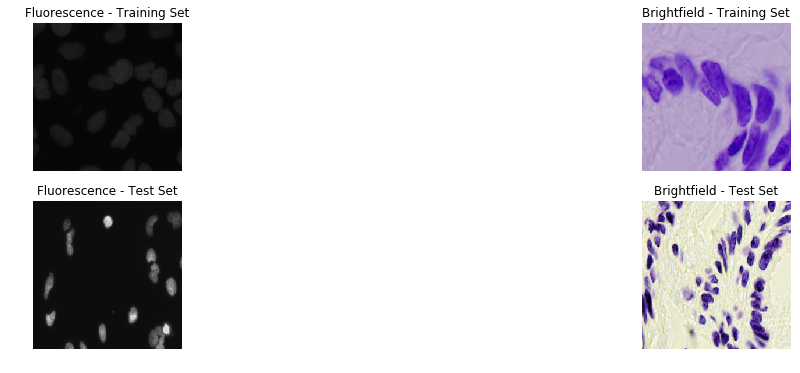

In [11]:
ix_0 = np.random.randint(0, len(train_dev_fluor_df['images']))
ix_1 = np.random.randint(0, len(train_dev_bright_df['images']))
ix_2 = np.random.randint(0, len(test_fluor_df['images']))
ix_3 = np.random.randint(0, len(test_bright_df['images']))

fig, axs = plt.subplots(2, 2, figsize= (20, 6))
    
axs[0][0].imshow(train_dev_fluor_df['images'].iloc[ix_0])
axs[0][0].axis('off')
axs[0][0].set_title('Fluorescence - Training Set')

axs[0][1].imshow(train_dev_bright_df['images'].iloc[ix_1])
axs[0][1].axis('off')
axs[0][1].set_title('Brightfield - Training Set')

axs[1][0].imshow(test_fluor_df['newImages'].iloc[ix_2])
axs[1][0].axis('off')
axs[1][0].set_title('Fluorescence - Test Set')

axs[1][1].imshow(test_bright_df['newImages'].iloc[ix_3])
axs[1][1].axis('off')
axs[1][1].set_title('Brightfield - Test Set')

plt.show()

## Separate Training Data into Fluorescence and Brightfield sets ***

For the Fluorescent Neural Network, there are 546 Training examples 

For the Brightfield Neural Network, there are 124 Training examples 



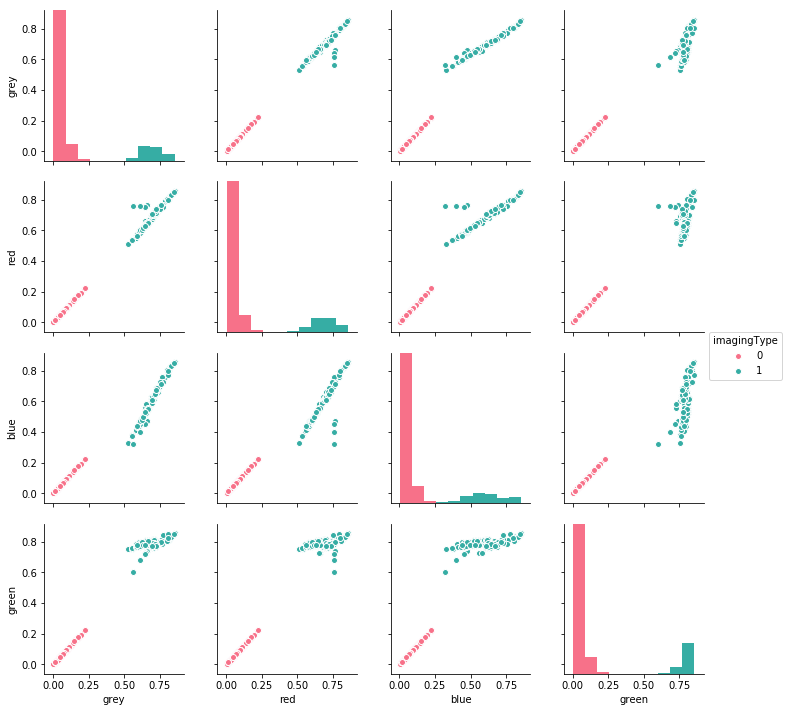

In [12]:
print('For the Fluorescent Neural Network, there are {} Training examples \n'.format(
    train_dev_fluor_df.shape[0]))

print('For the Brightfield Neural Network, there are {} Training examples \n'.format(
    train_dev_bright_df.shape[0]))


# Calculate means of each channel for each image
train_dev_img_df['red'] = train_dev_img_df['images'].map(lambda x: np.mean(x[:, :, 0]))
train_dev_img_df['blue'] = train_dev_img_df['images'].map(lambda x: np.mean(x[:, :, 1]))
train_dev_img_df['green'] = train_dev_img_df['images'].map(lambda x: np.mean(x[:, :, 2]))
train_dev_img_df['grey'] = train_dev_img_df['images'].map(lambda x: np.mean(x))

# Plot channel intensity means
sns.pairplot(train_dev_img_df, vars= ['grey', 'red', 'blue', 'green'], hue= 'imagingType', palette= 'husl')


## Fluorescent Set CNN
Make a very simple CNN to get a quick idea of how well it works.

For this we use batch normalisation to normalise the inputs. We cheat a bit with padding to keep problems simple.

In [13]:
# CNN Architecture for Fluorescent Microscope images

simple_cnn_fluorescent = Sequential()

simple_cnn_fluorescent.add(BatchNormalization(input_shape= (hyperparam_BSF_vals['IMG_WIDTH'], hyperparam_BSF_vals['IMG_HEIGHT'], hyperparam_BSF_vals['IMG_CHANNELS']), name= 'NormalizeInput'))

simple_cnn_fluorescent.add(Conv2D(8, kernel_size= 3, padding= 'same', activation= 'relu'))
simple_cnn_fluorescent.add(Dropout(0.2))
simple_cnn_fluorescent.add(Conv2D(8, kernel_size= 3, padding= 'same', activation= 'relu'))
simple_cnn_fluorescent.add(Dropout(0.2))
# Use dilations to get slightly larger field of view
simple_cnn_fluorescent.add(Conv2D(16, kernel_size= 3, dilation_rate= 2, padding= 'same', activation= 'relu'))
simple_cnn_fluorescent.add(Dropout(0.2))
simple_cnn_fluorescent.add(Conv2D(16, kernel_size= 3, dilation_rate= 2, padding= 'same', activation= 'relu'))
simple_cnn_fluorescent.add(Dropout(0.2))
simple_cnn_fluorescent.add(Conv2D(32, kernel_size= 3, dilation_rate= 3, padding= 'same', activation= 'relu'))
simple_cnn_fluorescent.add(Dropout(0.2))

# The final processing
simple_cnn_fluorescent.add(Conv2D(16, kernel_size= (1, 1), padding= 'same'))
simple_cnn_fluorescent.add(Conv2D(1, kernel_size= (1, 1), padding= 'same', activation= 'sigmoid'))

## Quick compile, in order to save initial weights so they can be restored in the hyperparameter sweeping loop
simple_cnn_fluorescent.compile(optimizer= 'adam', loss= dice_coef_loss, metrics= [dice_coef, 'acc', 'mse'])  
simple_cnn_fluorescent.save_weights('model.h5')

simple_cnn_fluorescent.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      1168      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 256, 16)      0         
__________

In [14]:
# CNN Architecture for Brightfield Microscope images

simple_cnn_brightfield = Sequential()

simple_cnn_brightfield.add(BatchNormalization(input_shape= 
                                              (hyperparam_BSF_vals['IMG_WIDTH'], hyperparam_BSF_vals['IMG_HEIGHT'], 
                                               hyperparam_BSF_vals['IMG_CHANNELS']), name= 'NormalizeInput'))

simple_cnn_brightfield.add(Conv2D(8, kernel_size= 3, padding= 'same', activation= 'relu'))
simple_cnn_brightfield.add(Dropout(0.2))
simple_cnn_brightfield.add(Conv2D(8, kernel_size= 3, padding= 'same', activation= 'relu'))
simple_cnn_brightfield.add(Dropout(0.2))
# Use dilations to get slightly larger field of view
simple_cnn_brightfield.add(Conv2D(16, kernel_size= 3, dilation_rate= 2, padding= 'same', activation= 'relu'))
simple_cnn_brightfield.add(Dropout(0.2))
simple_cnn_brightfield.add(Conv2D(16, kernel_size= 3, dilation_rate= 2, padding= 'same', activation= 'relu'))
simple_cnn_brightfield.add(Dropout(0.2))
simple_cnn_brightfield.add(Conv2D(32, kernel_size= 3, dilation_rate= 3, padding= 'same', activation= 'relu'))
simple_cnn_brightfield.add(Dropout(0.2))

# The final processing
simple_cnn_brightfield.add(Conv2D(16, kernel_size= (1, 1), padding= 'same'))
simple_cnn_brightfield.add(Conv2D(1, kernel_size= (1, 1), padding= 'same', activation= 'sigmoid'))

simple_cnn_brightfield.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
dropout_7 (Dropout)          (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 256, 16)      1168      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256, 256, 16)      0         
__________

In [24]:
def cnn_hyParam_training_sweep(n_iterations, simple_cnn, microscope, *swept_params):
    '''
    [int], [keras Sequential Model], [string], *[strings]  -->  [pd.DataFrame], [keras Sequential Model]
    
    Function takes in specified neural network, trains it "n_iterations" times, selecting different hyperparameters
    randomly selecting each argument of "*swept_params" each pass, and outputs a DataFrame storing the hyperparameters
    and corresponding Training and Dev Accuracies for each pass
    
    Inputs:
    1) number of training passes desired for the hyperparameter sweep. Set to 1 if just want to train the model once
    2) the CNN to be trained. Set to either "simple_cnn_fluorescent" or "simple_cnn_brightfield"
    3) string specifying microscope type of cnn to be trained. EITHER "fluorescent" OR "brightfield"
    4) strings corresponding to keys of the hyperparameter dictionary for variables desired to be swept
    
    Outputs:
    1) DataFrame containing hyperparameters and corresponding Train and Dev set accuracies for each pass in rows
    2) Trained cnn
    
    '''
    
    
    ## Restore BSF hyperparameter values (in case this function has been run more than once)
    hyperparam_BSF_vals = hyperparam_BSF_dict()
    
    ## Initialise sweep DataFrame which stores hyperparameter values and corresponding Train and Dev Accuracies 
    ## for each iteration
    
    # Row index and column labels for DataFrame
    columns = list(hyperparam_BSF_vals.keys())
    columns.extend(('Train_Accuracy', 'Dev_Accuracy'))
    index = range(n_iterations)    
    # Initialise empty DataFrame
    df_hyParam_training_sweep = pd.DataFrame(index=index, columns=columns)
    df_hyParam_training_sweep = df_hyParam_training_sweep.fillna(0) # with 0s rather than NaNs
    
    
    ## Initialise counter for While Loop
    count = 0
    
    
    while count < n_iterations:
        
        # Restore initial (Batch Normalised) weights of model, otherwise succeeding iterations of this loop
        # will train models with weights from earlier iterations rather than being independent
        simple_cnn.load_weights('model.h5')        
        print('Iteration number {} \n'.format(count + 1))
        

        ## Randomly sample hyperparameters for given swept_params, altering the "hyperparam_BSF_vals" dictionary in place
        swept_params = hyperparam_sweep(hyperparam_BSF_vals, *swept_params)
        for item in swept_params:
            print('{} = {} \n'.format(item, hyperparam_BSF_vals[item]))
        # Based on "microscope" input string, select hyperparams for either fluorescent or brightfield CNN
        if microscope == 'fluorescent':
            learning_rate = hyperparam_BSF_vals['LEARNING_RATE_FLUOR']
            minibatch = hyperparam_BSF_vals['MINIBATCH_FLUOR']
            epochs = hyperparam_BSF_vals['EPOCH_FLUOR']
            train_image_Series = train_dev_fluor_df['images']
            train_mask_Series = train_dev_fluor_df['masks']
        elif microscope == 'brightfield':
            learning_rate = hyperparam_BSF_vals['LEARNING_RATE_BRIGHT']
            minibatch = hyperparam_BSF_vals['MINIBATCH_BRIGHT']
            epochs = hyperparam_BSF_vals['EPOCH_BRIGHT'] 
            train_image_Series = train_dev_bright_df['images']
            train_mask_Series = train_dev_bright_df['masks']
        else:
            print('Didn\'t recognise \"microscope\" input string: training fluorescent network')
            learning_rate = hyperparam_BSF_vals['LEARNING_RATE_FLUOR']
            minibatch = hyperparam_BSF_vals['MINIBATCH_FLUOR']
            epochs = hyperparam_BSF_vals['EPOCH_FLUOR']
            train_image_Series = train_dev_fluor_df['images']
            train_mask_Series = train_dev_fluor_df['masks']
            
        ## Optimiser
        adam_optimiser = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


        ## Compile Model
        simple_cnn.compile(optimizer= adam_optimiser, loss= dice_coef_loss, metrics= [dice_coef, 'acc', 'mse'])    


        ## Train Model
        # pd.DataFrame to NumPy array for convenience
        X_train = imageSeries_to_ndArray(train_image_Series)
        y_train = maskSeries_to_ndArray(train_mask_Series)
        # Train CNN
        history = simple_cnn.fit(X_train, y_train, validation_split= hyperparam_BSF_vals['DEV_SPLIT'],
                       batch_size= minibatch, epochs= epochs)
        train_accuracy = history.history['acc']   # This will be a list, with an "acc" value for each epoch
        
        ## Evaluate accuracy for Train Set
#         train_accuracy = simple_cnn.evaluate(X_train, y_train)[2]
        print('Train set accuracy for {} Dataset is {}\n'.format(microscope,
            train_accuracy))

        ## Apply Model to Dev Set and calculate accuracy
        # Fluorescent Dev Set Data
#         X_dev = imageSeries_to_ndArray(dev_image_Series)
#         y_dev = maskSeries_to_ndArray(dev_mask_Series)

        ### CLEAN DATA

        ## Evaluate accuracy for Dev Set
        dev_accuracy = history.history['val_acc']   # This will be a list, with an "acc" value for each epoch
#         dev_accuracy = simple_cnn.evaluate(X_dev, y_dev)[2]
        print('Dev set accuracy for {} Dataset is {}\n'.format(microscope,
            dev_accuracy))
        
        iteration_dict = hyperparam_BSF_vals
        iteration_dict['Train_Accuracy'] = train_accuracy[-1]   # "-1" indexes last epoch accuracy from "history"
        iteration_dict['Dev_Accuracy'] = dev_accuracy[-1]   # "-1" indexes last epoch accuracy from "history"
        df_hyParam_training_sweep.iloc[count] = pd.Series(iteration_dict)
        
        # Update iterator for While Loop
        count += 1
    
    return df_hyParam_training_sweep, simple_cnn, history


## Epoch Sweeps

In [35]:
# Run the function to train fluorescent network
df_hyParam_training_sweep, simple_cnn_fluorescent, history_fluor = cnn_hyParam_training_sweep(
    1, simple_cnn_fluorescent, 'fluorescent')

Iteration number 1 

Train on 436 samples, validate on 110 samples
Epoch 1/10
436/436 [==============================] - 268s 615ms/step - loss: -0.3010 - dice_coef: 0.3010 - acc: 0.4112 - mean_squared_error: 0.3072 - val_loss: -0.3286 - val_dice_coef: 0.3286 - val_acc: 0.8007 - val_mean_squared_error: 0.2785
Epoch 2/10
436/436 [==============================] - 261s 598ms/step - loss: -0.4775 - dice_coef: 0.4775 - acc: 0.8574 - mean_squared_error: 0.1620 - val_loss: -0.7163 - val_dice_coef: 0.7163 - val_acc: 0.9231 - val_mean_squared_error: 0.0637
Epoch 3/10
436/436 [==============================] - 264s 605ms/step - loss: -0.7320 - dice_coef: 0.7320 - acc: 0.9199 - mean_squared_error: 0.0659 - val_loss: -0.7866 - val_dice_coef: 0.7866 - val_acc: 0.9414 - val_mean_squared_error: 0.0478
Epoch 4/10
436/436 [==============================] - 262s 601ms/step - loss: -0.7869 - dice_coef: 0.7869 - acc: 0.9359 - mean_squared_error: 0.0515 - val_loss: -0.8020 - val_dice_coef: 0.8020 - val_ac

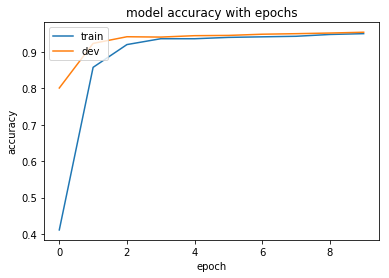

In [37]:
train_acc = history_fluor.history['acc']
dev_acc = history_fluor.history['val_acc']
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('model accuracy with epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [23]:
# ## Plot hyperparameter sweep
# x = np.log10(df_hyParam_training_sweep['LEARNING_RATE_FLUOR'])
# y1 = df_hyParam_training_sweep['Train_Accuracy']
# y2 = df_hyParam_training_sweep['Dev_Accuracy']

# plt.scatter(x, y1, c= 'r')
# axes = plt.gca()
# m, b = np.polyfit(x, y1, 2)
# X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
# plt.plot(X_plot, m*X_plot + b, '-')
# plt.scatter(np.log10(df_hyParam_training_sweep['LEARNING_RATE_FLUOR']), df_hyParam_training_sweep['Dev_Accuracy'], 
#             c= 'b')
# plt.show()

In [33]:
# Run the function to train brightfield network
df_hyParam_training_sweep, simple_cnn_brightfield, history_bright = cnn_hyParam_training_sweep(
    1, simple_cnn_brightfield, 'brightfield')

Iteration number 1 

Train on 99 samples, validate on 25 samples
Epoch 1/10
99/99 [==============================] - 66s 668ms/step - loss: -0.3553 - dice_coef: 0.3553 - acc: 0.1783 - mean_squared_error: 0.3079 - val_loss: -0.4547 - val_dice_coef: 0.4547 - val_acc: 0.5792 - val_mean_squared_error: 0.3175
Epoch 2/10
99/99 [==============================] - 65s 660ms/step - loss: -0.4045 - dice_coef: 0.4045 - acc: 0.5714 - mean_squared_error: 0.3379 - val_loss: -0.4756 - val_dice_coef: 0.4756 - val_acc: 0.7543 - val_mean_squared_error: 0.2561
Epoch 3/10
99/99 [==============================] - 60s 602ms/step - loss: -0.4310 - dice_coef: 0.4310 - acc: 0.7759 - mean_squared_error: 0.2350 - val_loss: -0.5055 - val_dice_coef: 0.5055 - val_acc: 0.8369 - val_mean_squared_error: 0.1937
Epoch 4/10
99/99 [==============================] - 64s 645ms/step - loss: -0.4774 - dice_coef: 0.4774 - acc: 0.8576 - mean_squared_error: 0.1687 - val_loss: -0.5794 - val_dice_coef: 0.5794 - val_acc: 0.8746 - va

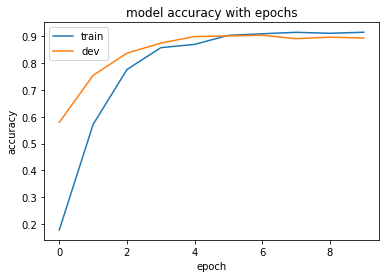

In [39]:
train_acc = history_bright.history['acc']
dev_acc = history_bright.history['val_acc']
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('model accuracy with epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## Learning Rate Sweep

## Display Train-Dev Set Predicted Masks

C:\Users\tomwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


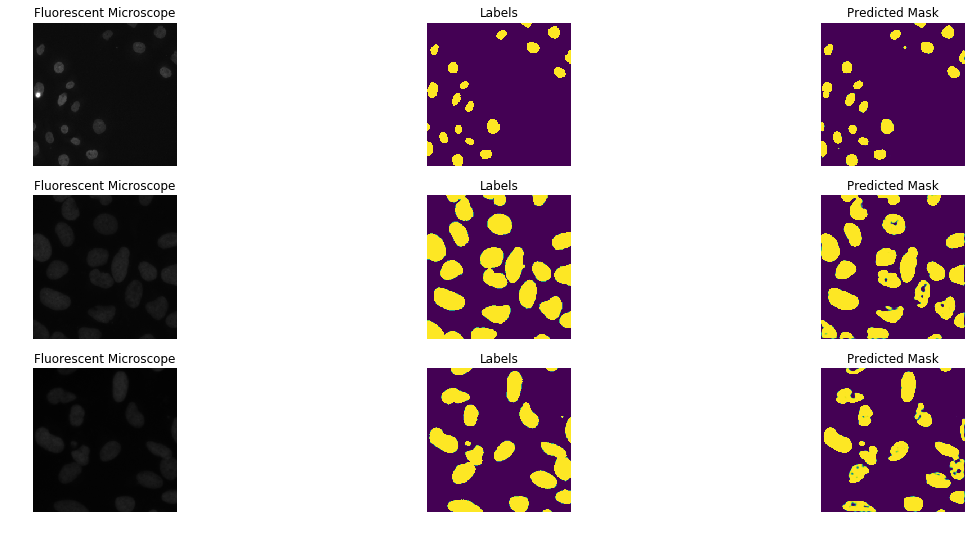

In [40]:
train_dev_fluor_df['predictions'] = train_dev_fluor_df['images'].map(lambda x: simple_cnn_fluorescent.predict(np.expand_dims(x, 0))[0, :, :, 0])

n_img = 3

fig, axes = plt.subplots(3, n_img, figsize = (20, 9))
for (_, d_row), (c_im, c_mask, c_pred) in zip(train_dev_fluor_df.sample(n_img).iterrows(), axes):
    
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Fluorescent Microscope')
    
    c_mask.imshow(d_row['masks'])
    c_mask.axis('off')
    c_mask.set_title('Labels')
    
    c_pred.imshow(d_row['predictions'])
    c_pred.axis('off')
    c_pred.set_title('Predicted Mask')


C:\Users\tomwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


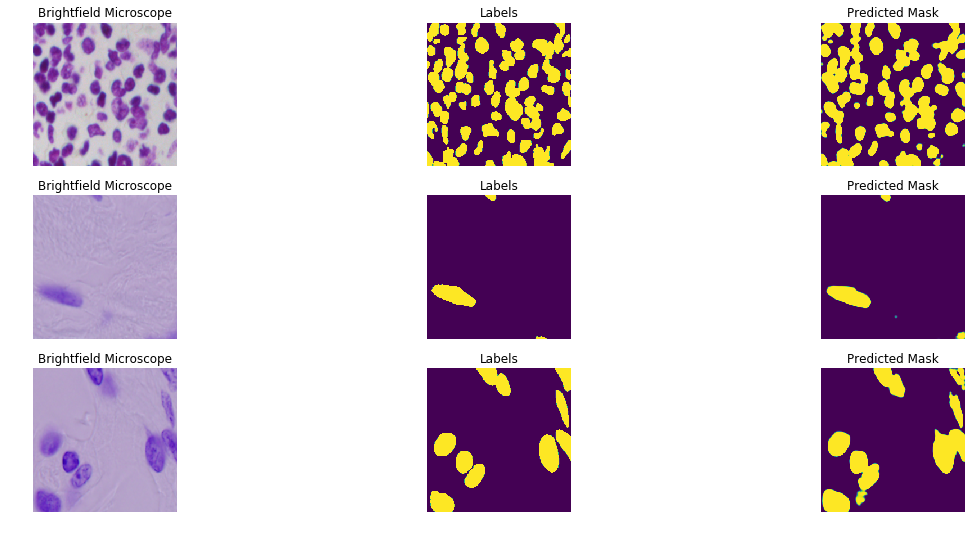

In [41]:
train_dev_bright_df['predictions'] = train_dev_bright_df['images'].map(lambda x: simple_cnn_brightfield.predict(np.expand_dims(x, 0))[0, :, :, 0])

n_img = 3

fig, axes = plt.subplots(3, n_img, figsize = (20, 9))
for (_, d_row), (c_im, c_mask, c_pred) in zip(train_dev_bright_df.sample(n_img).iterrows(), axes):
    
    c_im.imshow(d_row['images'])
    c_im.axis('off')
    c_im.set_title('Brightfield Microscope')
    
    c_mask.imshow(d_row['masks'])
    c_mask.axis('off')
    c_mask.set_title('Labels')
    
    c_pred.imshow(d_row['predictions'])
    c_pred.axis('off')
    c_pred.set_title('Predicted Mask')

## Apply Model to Test Data

In [43]:
%%time

# Fluorescence prediction from CNN
test_fluor_df['masks'] = test_fluor_df['newImages'].map(lambda x: simple_cnn_fluorescent.predict(np.expand_dims(x, 0))[0, :, :, 0])

Wall time: 9.67 s


C:\Users\tomwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
# Initialise new masks array
newMasks = []

for i in range(len(test_fluor_df['masks'])):
    original_dims = test_fluor_df['orig_img_shape'].iloc[i]    # Original dims is list of [height, width, channels]
#     print(original_dims)
#     Resize masks back to original size. np.squeeze removes any singe-dimensional entries eg shape (1, 3, 1) becomes (3, )
    newMasks.append(resize(np.squeeze(test_fluor_df['masks'].iloc[i]), 
                                                   (original_dims[0], original_dims[1]), 
                                                   mode='constant', preserve_range=True))

test_fluor_df['newMasks'] = newMasks  

C:\Users\tomwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [45]:
%%time

# Fluorescence prediction from CNN
test_bright_df['masks'] = test_bright_df['newImages'].map(lambda x: simple_cnn_brightfield.predict(np.expand_dims(x, 0))[0, :, :, 0])

Wall time: 2.35 s


C:\Users\tomwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
# Initialise new masks array
newMasks = []

for i in range(len(test_bright_df['masks'])):
    original_dims = test_bright_df['orig_img_shape'].iloc[i]    # Original dims is list of [height, width, channels]
#     print(original_dims)
#     Resize masks back to original size. np.squeeze removes any singe-dimensional entries eg shape (1, 3, 1) becomes (3, )
    newMasks.append(resize(np.squeeze(test_bright_df['masks'].iloc[i]), 
                                                   (original_dims[0], original_dims[1]), 
                                                   mode='constant', preserve_range=True))

test_bright_df['newMasks'] = newMasks  

C:\Users\tomwa\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


## Show a few predictions

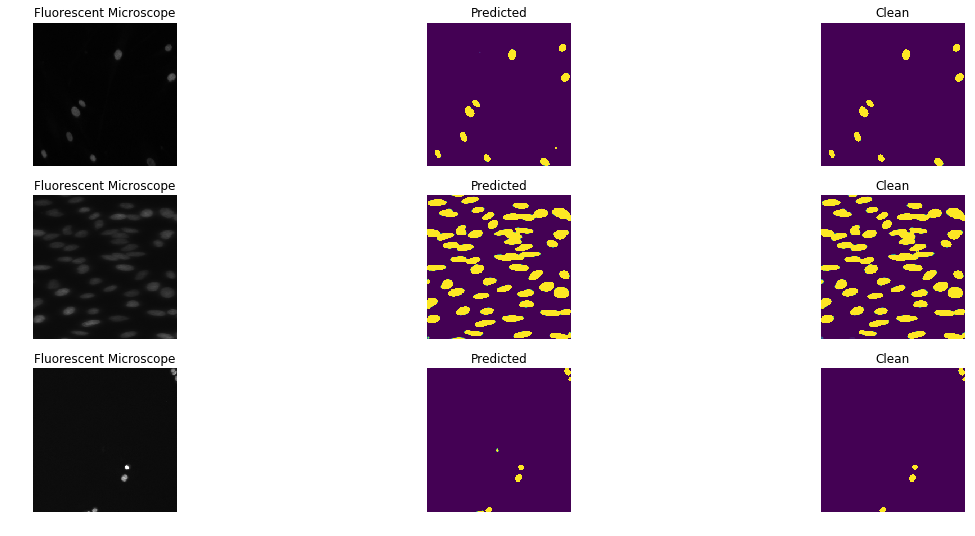

In [47]:
n_img = 3


fig, m_axs = plt.subplots(3, n_img, figsize = (20, 9))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_fluor_df.sample(n_img).iterrows(), m_axs):
    
    c_im.imshow(d_row['newImages'])
    c_im.axis('off')
    c_im.set_title('Fluorescent Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks'], hyperparam_BSF_vals['CLOSING_SIZE_FLUOR'], 
                             hyperparam_BSF_vals['OPENING_SIZE_FLUOR']))
    c_clean.axis('off')
    c_clean.set_title('Clean')
    
    

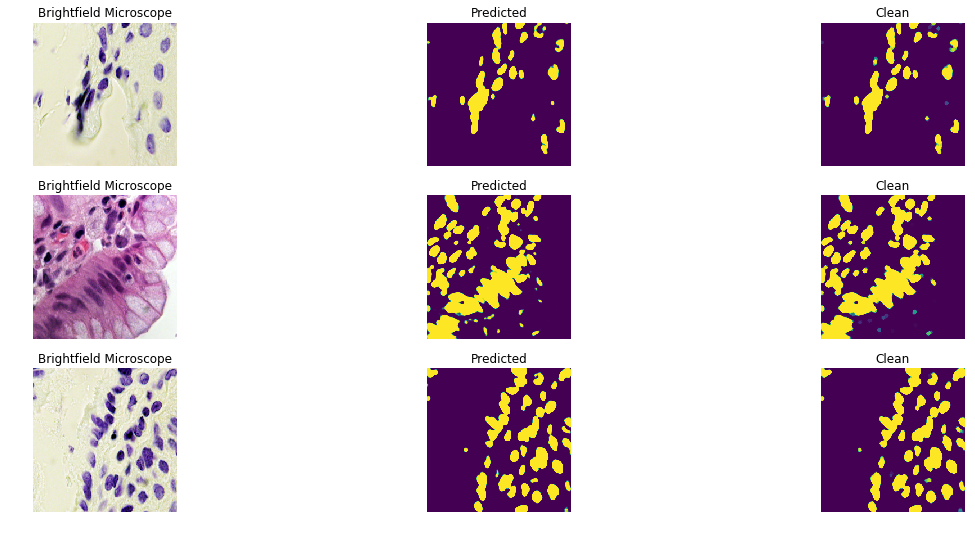

In [48]:
n_img = 3

def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

fig, m_axs = plt.subplots(3, n_img, figsize = (20, 9))
for (_, d_row), (c_im, c_lab, c_clean) in zip(test_bright_df.sample(n_img).iterrows(), m_axs):
    
    c_im.imshow(d_row['newImages'])
    c_im.axis('off')
    c_im.set_title('Brightfield Microscope')
    
    c_lab.imshow(d_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Predicted')
    
    c_clean.imshow(clean_img(d_row['masks']))
    c_clean.axis('off')
    c_clean.set_title('Clean')
    
    

## Calculate RLEs for all the Masks
Here we generate the RLE for all the masks and output the results to a table.

We use a few morphological operations to clean up the images before submission since they can be very messy (remove single pixels, connect nearby regions etc.)

In [49]:
# Concatenate Type 0 (Fluorescent) and Type 1 (Brightfield) DataFrames
frames = [test_fluor_df, test_bright_df]
test_img_df = pd.concat(frames)

In [50]:
test_img_df['rles'] = test_img_df['newMasks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))

In [51]:
out_pred_list = []
for _, c_row in test_img_df.iterrows():
    for c_rle in c_row['rles']:
        out_pred_list += [dict(ImageId = c_row['ImageId'], EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
out_pred_df.sample(3)

2096 regions found for 65 images


,EncodedPixels,ImageId
307,127921 2 128441 6 128961 8 129481 8 130001 9 1...,432f367a4c5b5674de2e2977744d10289a064e5704b21a...
1238,39877 4 40394 8 40913 9 41431 11 41950 11 4246...,ca20076870e8fb604e61802605a9ac45419c82dd3e2340...
1795,155228 1 155750 7 156272 11 156796 13 157319 1...,3c4c675825f7509877bc10497f498c9a2e3433bf922bd8...


In [52]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions2.csv', index = False)